<a href="https://colab.research.google.com/github/YugantGotmare/Deep_learning_project/blob/main/Transfer_Learning_for_Endoscopic_Image_Analysis_with_Kvasir.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download -d meetnagadia/kvasir-dataset

 99% 1.14G/1.15G [00:09<00:00, 124MB/s]
100% 1.15G/1.15G [00:10<00:00, 123MB/s]


In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/content/kvasir-dataset.zip')
zip_ref.extractall('/content/Data')
zip_ref.close()

In [22]:
import pandas as pd
import numpy as np
from tensorflow import keras
from keras.layers import Conv2D,MaxPool2D,Dropout,Dense,Flatten,MaxPooling2D
from keras.models import Sequential
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [21]:
data = '/content/Data/kvasir-dataset'

In [23]:
train_df = tf.keras.preprocessing.image_dataset_from_directory(
    data,
    # shuffle=True,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(224, 224),
    batch_size=32
)

test_df= tf.keras.preprocessing.image_dataset_from_directory(
    data,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(224, 224),
    batch_size=32
)

Found 4000 files belonging to 8 classes.
Using 3200 files for training.
Found 4000 files belonging to 8 classes.
Using 800 files for validation.


In [25]:
class_names = train_df.class_names
class_names

['dyed-lifted-polyps',
 'dyed-resection-margins',
 'esophagitis',
 'normal-cecum',
 'normal-pylorus',
 'normal-z-line',
 'polyps',
 'ulcerative-colitis']

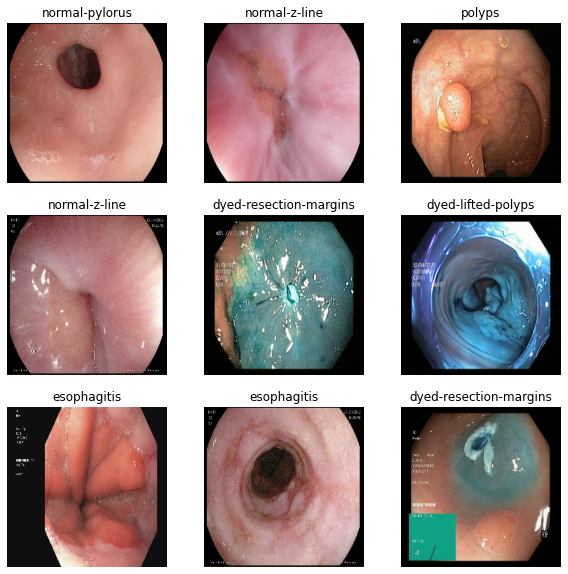

In [26]:
plt.figure(figsize=(10, 10))
for images, labels in train_df.take(1):
    for i in range(9):
      ax = plt.subplot(3, 3, i+1)
      plt.imshow(images[i].numpy().astype('uint8'))
      plt.title(class_names[labels[i]])
      plt.axis('off')

In [27]:
base_model = keras.applications.MobileNetV3Small(input_shape=(224,224,3),
classes=400,
include_top=False,
weights='imagenet')

In [28]:
base_model.trainable = False
base_model.summary()

Model: "MobilenetV3small"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['input_3[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['rescaling_1[0][0]']            
                                )                                                                 
                                                                                   

In [29]:
data_augmentation = keras.models.Sequential([
keras.layers.RandomFlip('horizontal'),
keras.layers.RandomRotation(0.2)
])

In [30]:
num_classes = len(class_names)

inputs = keras.Input(shape=(224, 224, 3))

x = data_augmentation(inputs)
x = keras.applications.mobilenet_v3.preprocess_input(inputs)
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)

outputs = keras.layers.Dense(num_classes, activation='softmax')(x)
model = keras.Model(inputs, outputs)

In [31]:
model.compile(optimizer='adam',
loss='sparse_categorical_crossentropy',
metrics=['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 MobilenetV3small (Functiona  (None, 7, 7, 576)        939120    
 l)                                                              
                                                                 
 global_average_pooling2d_1   (None, 576)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 576)               0         
                                                                 
 dense_1 (Dense)             (None, 8)                 4616      
                                                                 
Total params: 943,736
Trainable params: 4,616
Non-trainable

In [34]:
early = EarlyStopping(monitor='val_accuracy', min_delta=0.01, patience=1, verbose=1, mode='auto')

check = ModelCheckpoint(monitor='val_accuracy',filepath="./bestmodel.h5", save_best_only=True, verbose=1, mode='auto')

call = [early,check]

In [35]:
history = model.fit(train_df,
validation_data=test_df,
epochs=15,
callbacks=call)

Epoch 1/15
100/100 [==============================] - ETA: 0s - loss: 1.0135 - accuracy: 0.6419
Epoch 1: val_accuracy improved from -inf to 0.81750, saving model to ./bestmodel.h5
100/100 [==============================] - 85s 835ms/step - loss: 1.0135 - accuracy: 0.6419 - val_loss: 0.6367 - val_accuracy: 0.8175
Epoch 2/15
100/100 [==============================] - ETA: 0s - loss: 0.6251 - accuracy: 0.7784
Epoch 2: val_accuracy improved from 0.81750 to 0.85125, saving model to ./bestmodel.h5
100/100 [==============================] - 77s 753ms/step - loss: 0.6251 - accuracy: 0.7784 - val_loss: 0.4900 - val_accuracy: 0.8512
Epoch 3/15
100/100 [==============================] - ETA: 0s - loss: 0.5013 - accuracy: 0.8209
Epoch 3: val_accuracy improved from 0.85125 to 0.86500, saving model to ./bestmodel.h5
100/100 [==============================] - 82s 801ms/step - loss: 0.5013 - accuracy: 0.8209 - val_loss: 0.4202 - val_accuracy: 0.8650
Epoch 4/15
100/100 [==============================] 

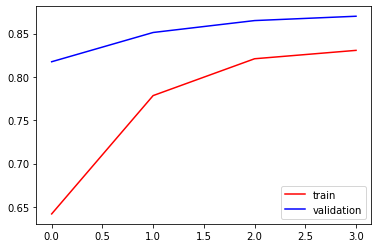

In [36]:
plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

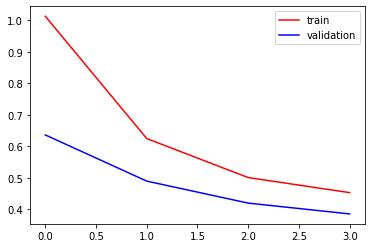

In [37]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

In [17]:
test_loss, test_acc = model.evaluate(test_data)
print('test accuracy : ', test_acc)

25/25 [==============================] - 17s 497ms/step - loss: 0.3797 - accuracy: 0.8725
test accuracy :  0.8725000023841858


In [18]:
results = model.evaluate(test_data, verbose=0)

In [19]:
print("Test Loss: {:.5f}".format(results[0]))
print("Accuracy on the test set: {:.2f}%".format(results[1] * 100))

Test Loss: 0.37965
Accuracy on the test set: 87.25%


1/1 [==============================] - 0s 388ms/step


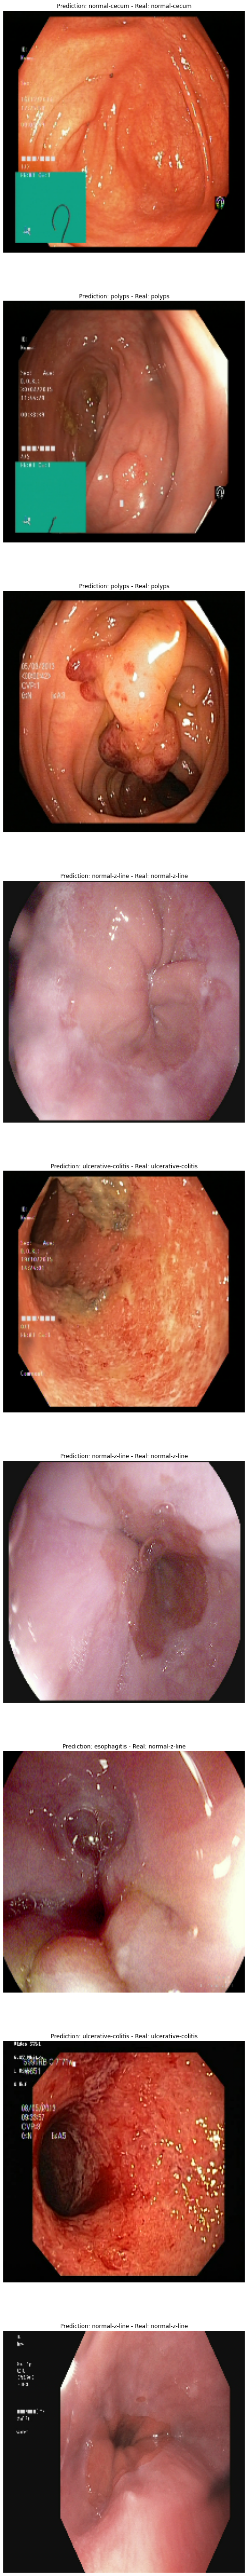

In [39]:
plt.figure(figsize=(10, 100))
for images, labels in test_data.take(1):
  prediction = model.predict(images,batch_size=32)
  for i in range(9):
    ax = plt.subplot(9, 1, i+1)
    pred = np.argmax(prediction[i])
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(f'Prediction: {class_names[pred]} - Real: {class_names[labels[i].numpy()]}')
    plt.axis('off')
#Visualize